In [2]:
import pandas as pd
import requests 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from pyfile.scrapestockdata import data_tsla, Trade_Buy, Trade_Sell
analyzer = SentimentIntensityAnalyzer()

In [3]:
news_df = pd.read_csv('tsla_merged.csv')

final_news = news_df.loc[:,['date','comment_text']]
final_news['date'] = pd.to_datetime(final_news['date'])
final_news.sort_values(by='date',inplace=True)
final_news

,date,comment_text
368,2023-10-20 03:26:10,"TL,DR: tesla is fucked."
378,2023-10-20 03:38:00,Fucked
370,2023-10-20 05:09:01,Wouldn’t it be safe to say that Tesla has grea...
372,2023-10-20 05:29:44,Proper fucked
367,2023-10-20 06:24:40,"Turns out, Tesla is a car company"
...,...,...
504,2024-01-30 10:08:37,Tesla haters is basically a cult in itself. An...
450,2024-01-30 10:09:18,"And the scary thing is, they can be worth mult..."
457,2024-01-30 10:10:38,Yes you sold. Easy now to be on the flip side....
1420,2024-01-30 13:27:24,"Lol, I Day traded today tsla to the long side ..."


In [4]:
# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay

# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None

In [5]:
 # Apply the above function to get the trading time for each news headline
final_news["trading_time"] = final_news["date"].apply(get_trade_open)

final_news = final_news[pd.notnull(final_news['trading_time'])]
final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)
final_news

C:\Users\DELL\AppData\Local\Temp\ipykernel_22240\116486405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)


,date,comment_text,trading_time,Date
368,2023-10-20 03:26:10,"TL,DR: tesla is fucked.",2023-10-20 13:30:00,2023-10-20
378,2023-10-20 03:38:00,Fucked,2023-10-20 13:30:00,2023-10-20
370,2023-10-20 05:09:01,Wouldn’t it be safe to say that Tesla has grea...,2023-10-20 13:30:00,2023-10-20
372,2023-10-20 05:29:44,Proper fucked,2023-10-20 13:30:00,2023-10-20
367,2023-10-20 06:24:40,"Turns out, Tesla is a car company",2023-10-20 13:30:00,2023-10-20
...,...,...,...,...
2212,2024-01-30 09:58:07,honestly elon laughing on the earnings call wa...,2024-01-30 13:30:00,2024-01-30
504,2024-01-30 10:08:37,Tesla haters is basically a cult in itself. An...,2024-01-30 13:30:00,2024-01-30
450,2024-01-30 10:09:18,"And the scary thing is, they can be worth mult...",2024-01-30 13:30:00,2024-01-30
457,2024-01-30 10:10:38,Yes you sold. Easy now to be on the flip side....,2024-01-30 13:30:00,2024-01-30


In [6]:
# getting compound for each news headline
cs = []
for row in range(len(final_news)):
    cs.append(analyzer.polarity_scores(final_news['comment_text'].iloc[row])['compound'])

final_news['compound_vader_score'] = cs
final_news

C:\Users\DELL\AppData\Local\Temp\ipykernel_22240\640652271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_news['compound_vader_score'] = cs


,date,comment_text,trading_time,Date,compound_vader_score
368,2023-10-20 03:26:10,"TL,DR: tesla is fucked.",2023-10-20 13:30:00,2023-10-20,-0.6597
378,2023-10-20 03:38:00,Fucked,2023-10-20 13:30:00,2023-10-20,-0.6597
370,2023-10-20 05:09:01,Wouldn’t it be safe to say that Tesla has grea...,2023-10-20 13:30:00,2023-10-20,0.5423
372,2023-10-20 05:29:44,Proper fucked,2023-10-20 13:30:00,2023-10-20,-0.6597
367,2023-10-20 06:24:40,"Turns out, Tesla is a car company",2023-10-20 13:30:00,2023-10-20,0.0000
...,...,...,...,...,...
2212,2024-01-30 09:58:07,honestly elon laughing on the earnings call wa...,2024-01-30 13:30:00,2024-01-30,0.7351
504,2024-01-30 10:08:37,Tesla haters is basically a cult in itself. An...,2024-01-30 13:30:00,2024-01-30,-0.4939
450,2024-01-30 10:09:18,"And the scary thing is, they can be worth mult...",2024-01-30 13:30:00,2024-01-30,-0.3182
457,2024-01-30 10:10:38,Yes you sold. Easy now to be on the flip side....,2024-01-30 13:30:00,2024-01-30,0.1531


In [7]:
final_news = final_news[(final_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)
final_news

,date,comment_text,trading_time,Date,compound_vader_score
0,2023-10-20 03:26:10,"TL,DR: tesla is fucked.",2023-10-20 13:30:00,2023-10-20,-0.6597
1,2023-10-20 03:38:00,Fucked,2023-10-20 13:30:00,2023-10-20,-0.6597
2,2023-10-20 05:09:01,Wouldn’t it be safe to say that Tesla has grea...,2023-10-20 13:30:00,2023-10-20,0.5423
3,2023-10-20 05:29:44,Proper fucked,2023-10-20 13:30:00,2023-10-20,-0.6597
4,2023-10-20 07:32:13,It’s all finally catching up to them. It was g...,2023-10-20 13:30:00,2023-10-20,0.4404
...,...,...,...,...,...
2364,2024-01-30 09:58:07,honestly elon laughing on the earnings call wa...,2024-01-30 13:30:00,2024-01-30,0.7351
2365,2024-01-30 10:08:37,Tesla haters is basically a cult in itself. An...,2024-01-30 13:30:00,2024-01-30,-0.4939
2366,2024-01-30 10:09:18,"And the scary thing is, they can be worth mult...",2024-01-30 13:30:00,2024-01-30,-0.3182
2367,2024-01-30 10:10:38,Yes you sold. Easy now to be on the flip side....,2024-01-30 13:30:00,2024-01-30,0.1531


In [8]:
# Retaining extreme (max and min) compound scores for same Day news headlines
unique_dates = final_news['Date'].unique()
grouped_dates = final_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)

In [9]:
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

#summing and calculating Vader score
final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores
extreme_scores_df

,Date,max_scores,min_scores,final_scores
0,2023-10-20,0.8580,-0.6597,0.1983
1,2023-10-23,0.5859,0.0000,0.5859
2,2023-10-30,0.0000,-0.2960,-0.2960
3,2023-11-10,0.8271,-0.9362,-0.1091
4,2023-11-13,0.9774,-0.7964,0.1810
5,2023-11-20,0.3612,0.0000,0.3612
6,2023-11-22,0.9216,-0.8402,0.0814
7,2023-11-23,0.8992,-0.9072,-0.0080
8,2023-11-24,0.8935,-0.9068,-0.0133
9,2023-11-27,0.6597,-0.4329,0.2268


In [13]:
#Using final compound VADER scores with threshold to generate trade calls
# VADER trade calls - with threshold
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())
print(vader_Buy)
print(vader_Sell)

vader_buy = []
for i in range(len(data_tsla)):
    if data_tsla.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(data_tsla)):
    if data_tsla.index[i].date() in vader_Sell:
        vader_sell.append(i)

print(vader_buy)
print(vader_sell)

Trade Call for 2023-10-23 is Buy.
Trade Call for 2023-10-30 is Sell.
Trade Call for 2023-11-20 is Buy.
Trade Call for 2023-11-27 is Buy.
Trade Call for 2024-01-01 is Buy.
Trade Call for 2024-01-09 is Buy.
Trade Call for 2024-01-11 is Buy.
Trade Call for 2024-01-15 is Buy.
Trade Call for 2024-01-24 is Buy.
Trade Call for 2024-01-30 is Buy.
[datetime.date(2023, 10, 23), datetime.date(2023, 11, 20), datetime.date(2023, 11, 27), datetime.date(2024, 1, 1), datetime.date(2024, 1, 9), datetime.date(2024, 1, 11), datetime.date(2024, 1, 15), datetime.date(2024, 1, 24), datetime.date(2024, 1, 30)]
[datetime.date(2023, 10, 30)]
[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203]
[]


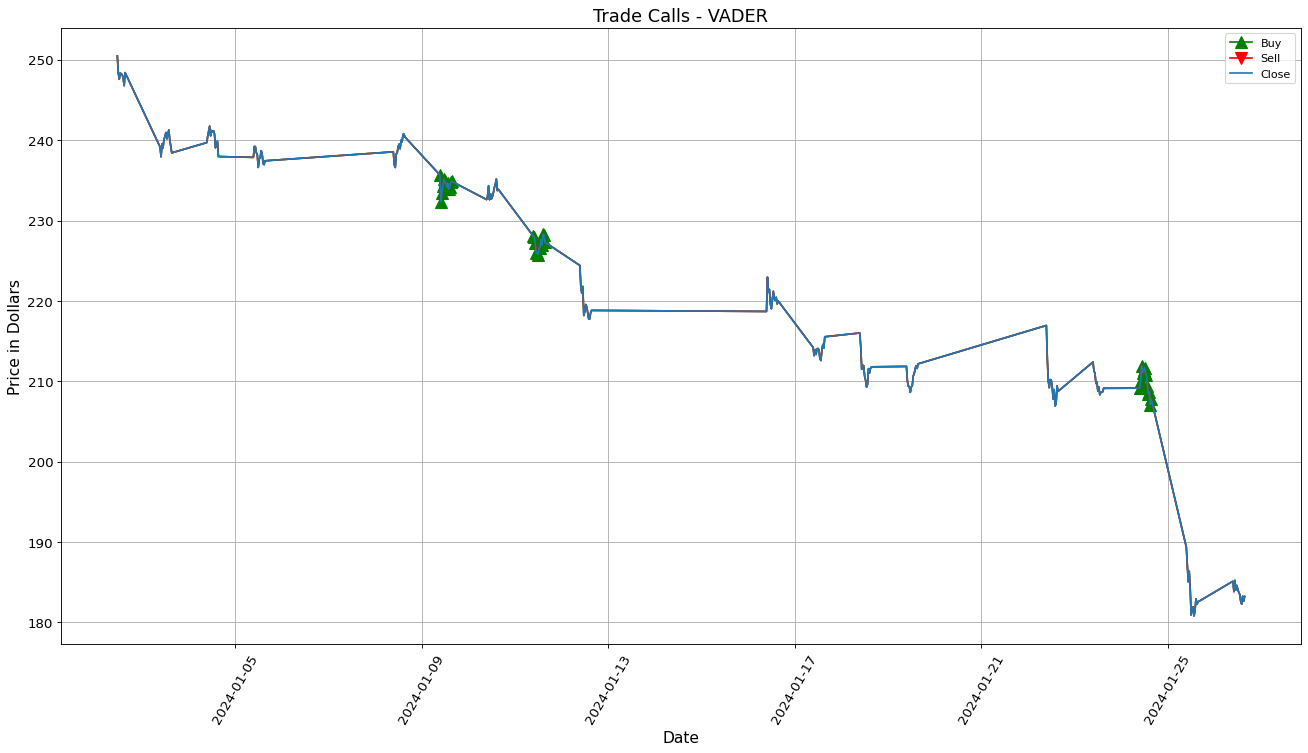

In [11]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_tsla.index, data_tsla['Close'],'-^', markevery=vader_buy, ms=10, color='green')
plt.plot(data_tsla.index, data_tsla['Close'],'-v', markevery=vader_sell, ms=10, color='red')
plt.plot(data_tsla.index, data_tsla['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

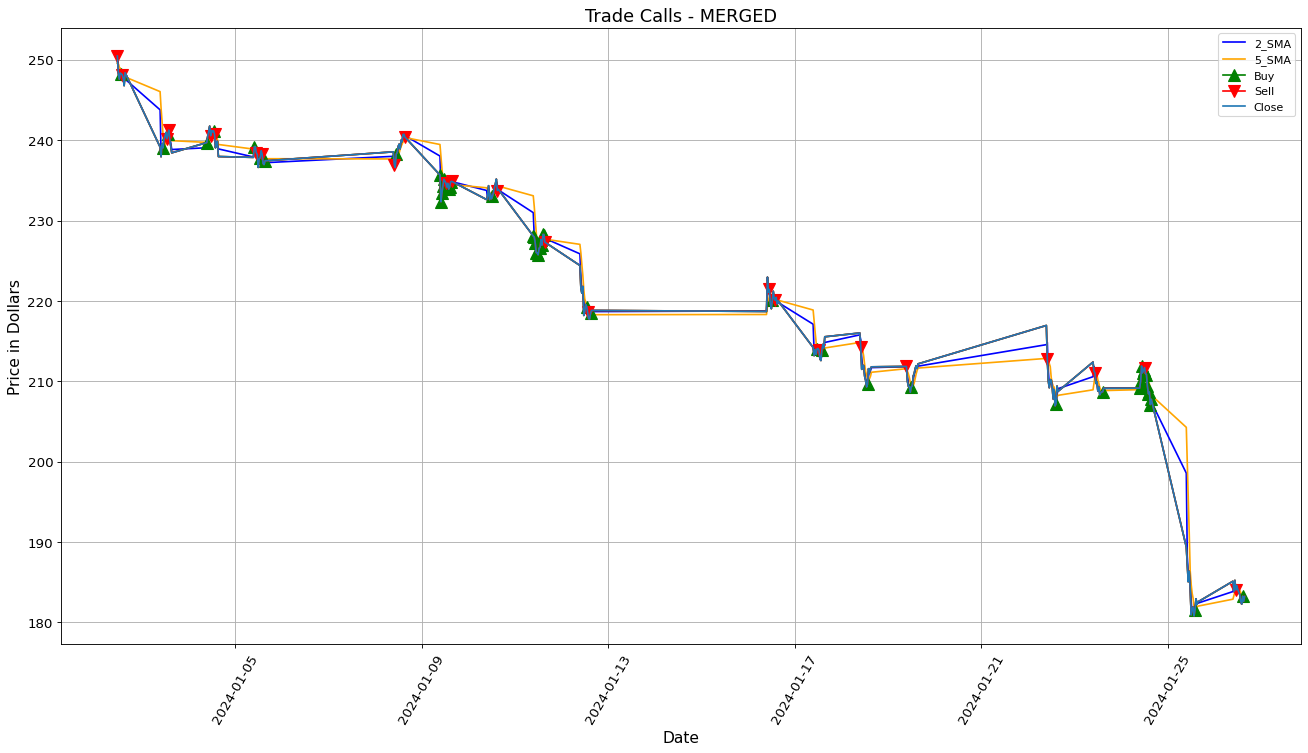

In [12]:
#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_tsla.index, data_tsla['2_SMA'], color='blue')
plt.plot(data_tsla.index, data_tsla['5_SMA'], color='orange')
plt.plot(data_tsla.index, data_tsla['Close'],'-^', markevery=final_buy, ms=10, color='green')
plt.plot(data_tsla.index, data_tsla['Close'],'-v', markevery=final_sell, ms=10, color='red')
plt.plot(data_tsla.index, data_tsla['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show() 

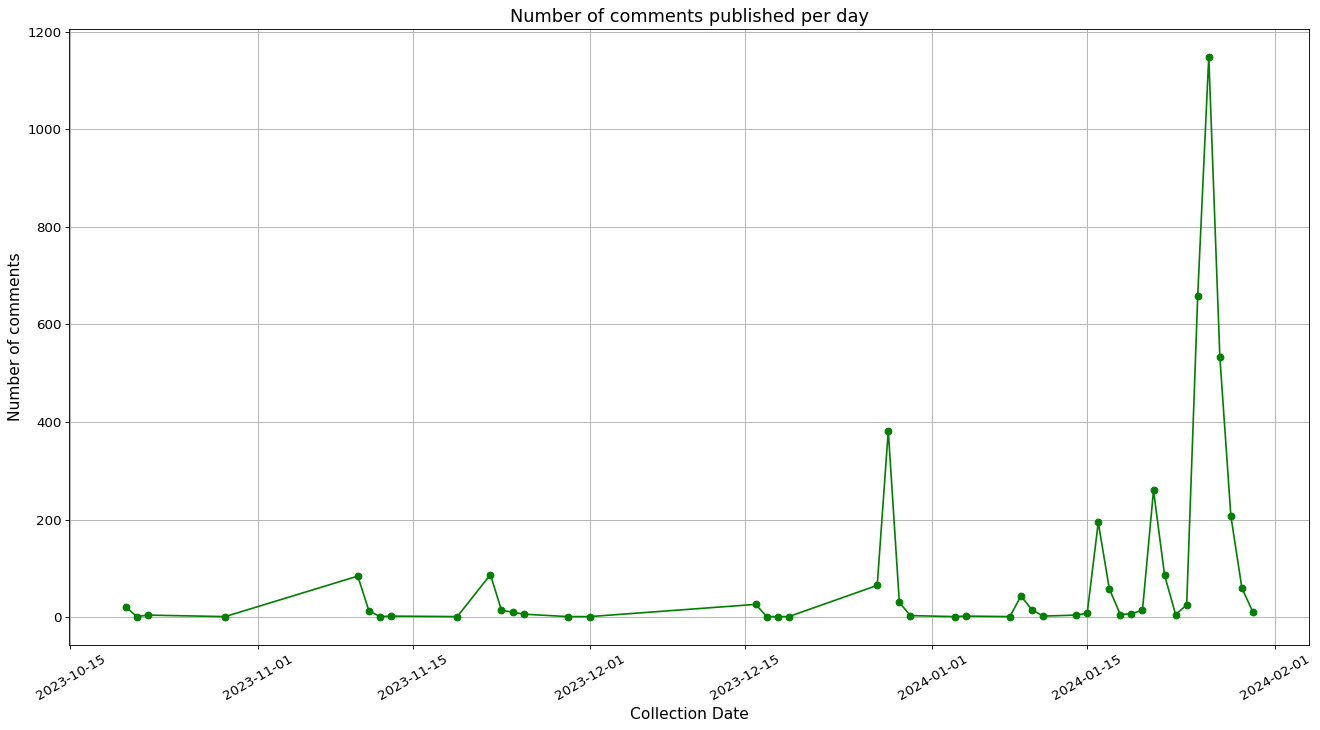

In [15]:
import matplotlib.pyplot as plt

# Đảm bảo rằng cột 'date' là kiểu dữ liệu datetime
news_df['date'] = pd.to_datetime(news_df['date'])
news_df['Date'] = news_df['date'].dt.date

# Tính toán số lượng content mỗi ngày
content_count = news_df.groupby('Date').size()

# Vẽ biểu đồ
plt.figure(figsize=(20,10), dpi=80)
content_count.plot(kind='line', marker='o', color='green')
plt.title('Number of comments published per day', fontsize = 16)
plt.xlabel('Collection Date', fontsize=14)
plt.ylabel('Number of comments',fontsize = 14)
plt.xticks(rotation=30,fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()